# Bibliotecas

In [496]:
import numpy as np
from numpy import unique

import pandas as pd

import os

from scipy.optimize import minimize
from scipy import stats
import scipy.stats as stats

from tqdm import tqdm

import warnings

from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV, LassoCV, Lasso, LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import seaborn as sns

import random

import pickle

# 1. Descrição dos Dados

O dataset contém informações tabulares organizadas em arquivo no formato CSV. Ele compreende diversas variáveis coletadas a partir de instrumentos clínicos
e de pesquisa, totalizando medições relacionadas à demografia, atividade física, saúde mental e comportamental, e características físicas dos participantes.

As variáveis são:

- Demographics: informações sobre idade e sexo dos participantes.

- Internet Use: número de horas de uso diário de computadores e internet.

- Children's Global assessment Scale: escala numérica usada por clínicos para avaliar o funcionamento geral de crianças e adolescentes menores de 18 anos.

- Physical Measures: conjunto de dados sobre pressão arterial, frequência cardíaca, altura, peso e medidas da cintura e quadril.

- FitnessGram Vitals and Treadmill: avaliações de aptidão cardiovascular baseadas em protocolos de esteira.

- FitnessGram Child: dados relacionados à aptidão física de crianças, incluindo capacidade aeróbica, força muscular e flexibilidade.

- Bio-electric impedance Analysis: medições de composição corporal, como IMC, percentual de gordura, massa muscular e conteúdo hídrico.

- Physical Activity Questionnaire: informações sobre a participação das crianças em atividades físicas vigorosas nos últimos sete dias.

- Sleep Disturbance Scale: escala utilizada para categorizar distúrbios do sono em crianças.

- Parent-Child Internet Addiction Test (PCIAT): escala composta por 20 itens para medir características associadas ao uso compulsivo da internet, como dependência e obsessão.

O objetivo do dataset é prever o índice de gravidade de comprometimento (Severity Impairment Index - sii), que é derivado do campo PCIAT-PCIAT_Total. A variável-alvo sii é categórica e possui quatro níveis: 0 (Nenhum), 1 (Leve), 2 (Moderado) e 3 (Grave).


In [556]:
#load Data
data = pd.read_csv('train.csv')

In [557]:
data.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.1 Análise do Dicionário dos Dados

In [558]:
#load dicionário
data_dictionary = pd.read_csv('data_dictionary.csv')
data_dictionary.head(81)

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
5,Children's Global Assessment Scale,CGAS-CGAS_Score,Children's Global Assessment Scale Score,int,NaN,NaN
6,Physical Measures,Physical-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
7,Physical Measures,Physical-BMI,Body Mass Index (kg/m^2),float,NaN,NaN
8,Physical Measures,Physical-Height,Height (in),float,NaN,NaN
9,Physical Measures,Physical-Weight,Weight (lbs),float,NaN,NaN


In [559]:
# Verificar se existe alguma linha onde o valor da coluna 'Field' é sii
if (data_dictionary['Field'] == 'sii').any():
    print("A linha com o nome da coluna do target existe.")
else:
    print("Não existe o nome da coluna do target.")


Não existe o nome da coluna do target.


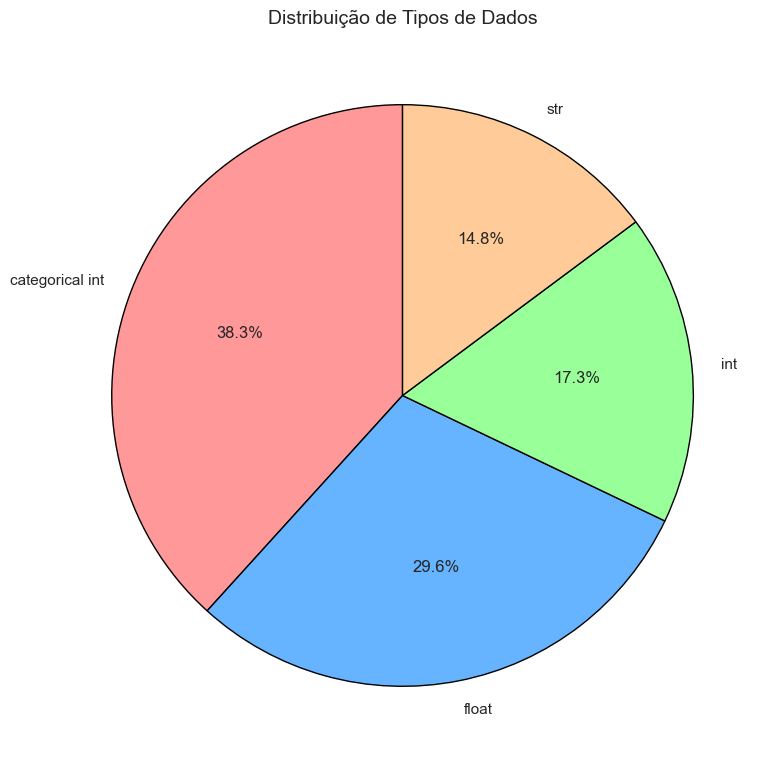

In [560]:
# Contar os valores únicos na coluna 'Type'
type_counts = data_dictionary['Type'].value_counts()

# Definir cores distintas para as fatias da pizza (personalizável)
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', 
          '#ffb3e6', '#c2f0c2', '#c9b6e4', '#f4c2c2', '#f6f6ae', 
          '#add8e6', '#d3d3d3']

# Criar o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', colors=colors[:len(type_counts)], startangle=90, wedgeprops={'edgecolor': 'black'})

# Adicionar título
plt.title('Distribuição de Tipos de Dados', fontsize=14)

# Ajustar layout
plt.tight_layout()
plt.show()


- Categorical int - dados que estão númericos, mas representão categorias, portanto são dados categóricos.
- str - dados categóricos
- int - númerico Discreto 
- float - númerico contínuo

In [561]:
# Filtrar o DataFrame para incluir apenas linhas onde 'Type' seja 'str' ou 'categorical int'
filtered_1 = data_dictionary[data_dictionary['Type'].isin(['str','categorical int'])]
filtered_2 = data_dictionary[data_dictionary['Type'].isin(['int', 'float'])]

# Obter os valores únicos da coluna 'Field' para essas linhas filtradas
field_list_categorical = filtered_1['Field'].tolist()
field_list_numerical = filtered_2['Field'].tolist()

# Exibir a lista resultante
print(field_list_categorical)
print(field_list_numerical)


['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Sex', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'PAQ_A-Season', 'PAQ_C-Season', 'PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'SDS-Season', 'PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday']
['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physic

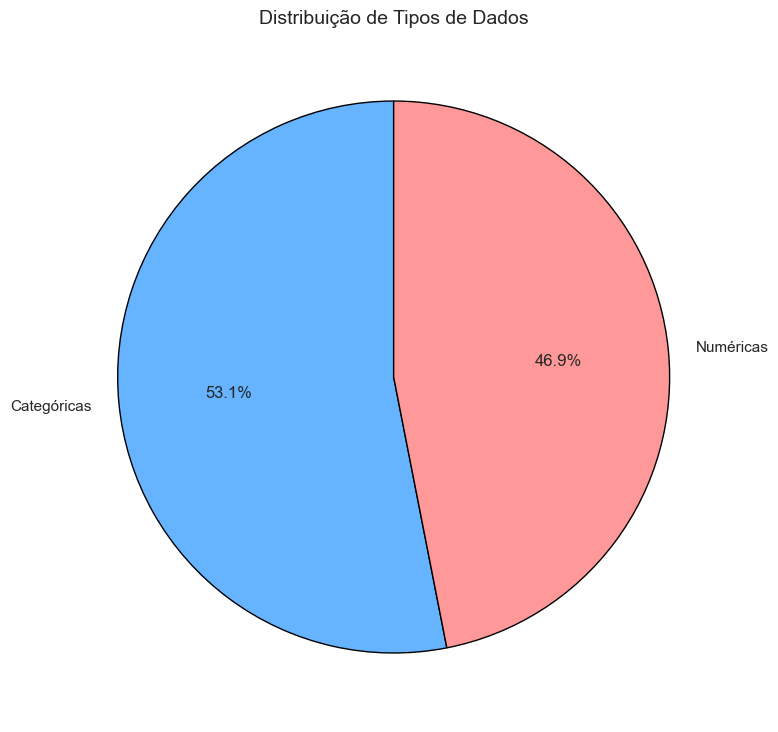

In [562]:
import pandas as pd
import matplotlib.pyplot as plt

# Agrupar os tipos em duas categorias
def categorize_type(value):
    if value in ['str', 'categorical int']:
        return 'Categóricas'
    elif value in ['int', 'float']:
        return 'Numéricas'
    else:
        return 'Outros'

# Criar nova coluna com as categorias agrupadas
data_dictionary['Grouped_Type'] = data_dictionary['Type'].apply(categorize_type)

# Contar os valores únicos nas categorias agrupadas
grouped_counts = data_dictionary['Grouped_Type'].value_counts()

# Definir cores distintas para as fatias da pizza
colors = ['#66b3ff', '#ff9999']

# Criar o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(grouped_counts, 
        labels=grouped_counts.index, 
        autopct='%1.1f%%', 
        colors=colors[:len(grouped_counts)], 
        startangle=90, 
        wedgeprops={'edgecolor': 'black'})

# Adicionar título
plt.title('Distribuição de Tipos de Dados', fontsize=14)

# Ajustar layout
plt.tight_layout()
plt.show()


In [563]:
data_dictionary.head()

,Instrument,Field,Description,Type,Values,Value Labels,Grouped_Type
0,Identifier,id,Participant's ID,str,NaN,NaN,Categóricas
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN,Categóricas
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN,Numéricas
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female",Categóricas
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN,Categóricas


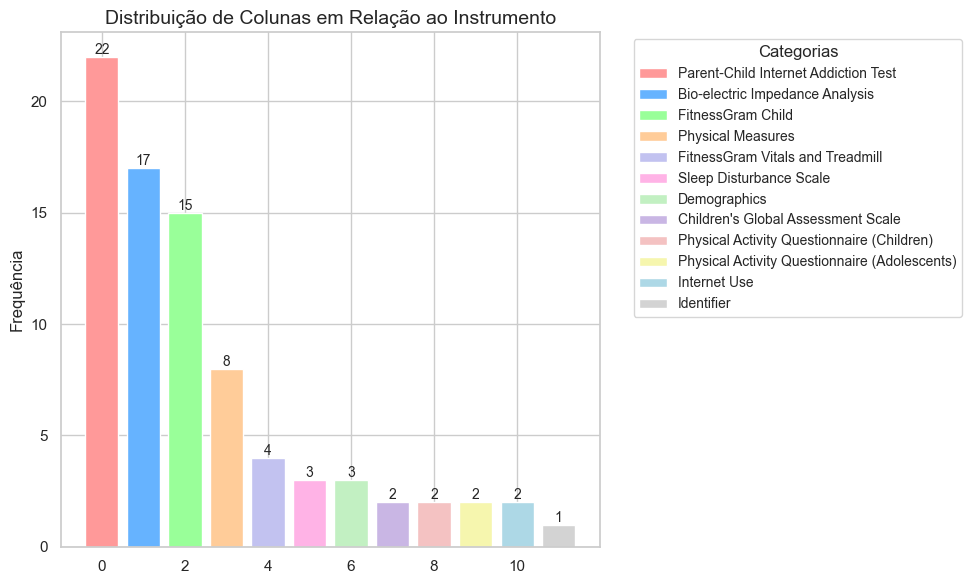

In [564]:
# Contar os valores únicos na primeira coluna
category_counts = data_dictionary['Instrument'].value_counts()

# Definir cores distintas para as barras (personalizável)
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', 
          '#ffb3e6', '#c2f0c2', '#c9b6e4', '#f4c2c2', '#f6f6ae', 
          '#add8e6', '#d3d3d3']

# Cria o gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(category_counts)), category_counts, color=colors[:len(category_counts)])

# Adiciona rótulos e título
plt.ylabel('Frequência', fontsize=12)
plt.title('Distribuição de Colunas em Relação ao Instrumento', fontsize=14)

# Adiciona os valores no topo das barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom', fontsize=10)

# legenda
legend_labels = [f'{label}' for label in category_counts.index]
plt.legend(bars, legend_labels, title="Categorias", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Ajusta layout para a legenda
plt.tight_layout()
plt.show()


# 2 Preparação dos Dados

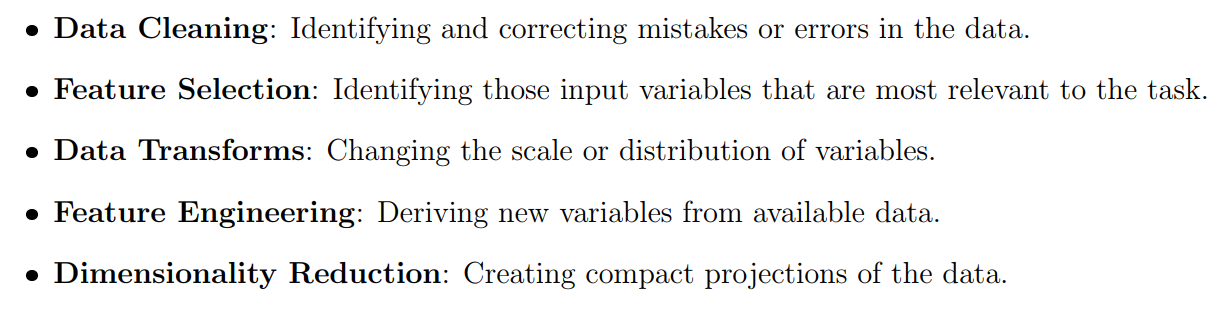

## 2.1 Data Cleaning

### 2.1.1 Basic Data Cleaning

#### 2.1.1.1 Identificar Colunas que Contém um único Valor

In [565]:
# Flag para verificar se há colunas com apenas um valor único
coluna_com_valor_unico = False

# Resumir o número de valores únicos em cada coluna e verificar colunas com um único valor
for i, column in enumerate(data.columns):
    unique_values = data[column].nunique()
    #print(i, column, unique_values)
    
    # Verificar se a coluna tem apenas um valor único
    if unique_values == 1:
       # print(f"  A coluna '{column}' tem apenas um valor único.")
        coluna_com_valor_unico = True

# Mensagem final caso não haja colunas com valor único
if not coluna_com_valor_unico:
    print("Não há nenhuma coluna com um valor único.")


Não há nenhuma coluna com um valor único.


#### 2.1.1.2 Colunas com Muitos Poucos Valores

Aplica-se apenas as colunas númericas.

In [566]:
# Função para resumir a porcentagem de valores únicos para colunas específicas
def analisar_colunas(data, colunas):
    for col in colunas:
        if col in data.columns:
            num_unique = data[col].nunique()  # Número de valores únicos
            percentage = (num_unique / len(data)) * 100  # Porcentagem de valores únicos
            print(f'Coluna: {col}, Valores únicos: {num_unique}, Porcentagem: {percentage:.1f}%')
        else:
            print(f'A coluna "{col}" não está no DataFrame.')

# Chamar a função com o DataFrame e a lista de colunas
analisar_colunas(data, field_list_numerical)


Coluna: Basic_Demos-Age, Valores únicos: 18, Porcentagem: 0.5%
Coluna: CGAS-CGAS_Score, Valores únicos: 59, Porcentagem: 1.5%
Coluna: Physical-BMI, Valores únicos: 2658, Porcentagem: 67.1%
Coluna: Physical-Height, Valores únicos: 306, Porcentagem: 7.7%
Coluna: Physical-Weight, Valores únicos: 783, Porcentagem: 19.8%
Coluna: Physical-Waist_Circumference, Valores únicos: 44, Porcentagem: 1.1%
Coluna: Physical-Diastolic_BP, Valores únicos: 102, Porcentagem: 2.6%
Coluna: Physical-HeartRate, Valores únicos: 88, Porcentagem: 2.2%
Coluna: Physical-Systolic_BP, Valores únicos: 129, Porcentagem: 3.3%
Coluna: Fitness_Endurance-Max_Stage, Valores únicos: 15, Porcentagem: 0.4%
Coluna: Fitness_Endurance-Time_Mins, Valores únicos: 18, Porcentagem: 0.5%
Coluna: Fitness_Endurance-Time_Sec, Valores únicos: 60, Porcentagem: 1.5%
Coluna: FGC-FGC_CU, Valores únicos: 59, Porcentagem: 1.5%
Coluna: FGC-FGC_GSND, Valores únicos: 341, Porcentagem: 8.6%
Coluna: FGC-FGC_GSD, Valores únicos: 350, Porcentagem: 8.8

Executando o exemplo, podemos ver que algumas colunas ​​têm variáveis ​​numéricas que têm valores únicos que são menores que 1 por cento do número de linhas. Isso não significa que
essas linhas e colunas devem ser excluídas, mas elas exigem mais atenção. Por exemplo:
- Talvez possam ser codificados como valores ordinais?
- Talvez possam ser codificados como valores categóricos?
- Talvez comparar a habilidade do modelo com cada variável removida do conjunto de dados?

#### 2.1.1.3 Identificando Linhas com Dados Duplicados

In [567]:
# Verificar linhas duplicadas
linhas_duplicadas = data.duplicated()

# Exibir se há linhas duplicadas
if linhas_duplicadas.any():
    print(f'Existem {linhas_duplicadas.sum()} linhas duplicadas.')
    # Exibir as linhas duplicadas (opcional)
    print("\nLinhas duplicadas:")
    print(data[linhas_duplicadas])
else:
    print("Não há linhas duplicadas no DataFrame, portanto.")


Não há linhas duplicadas no DataFrame, portanto.


In [568]:
# Escolher a coluna para verificar
coluna = 'id'  # Substitua pelo nome da coluna

# Verificar valores duplicados na coluna
valores_duplicados = data[coluna].duplicated()

# Exibir resultados
if valores_duplicados.any():
    print(f"A coluna '{coluna}' contém {valores_duplicados.sum()} valores duplicados.")
    # Exibir os valores duplicados (opcional)
    print("\nValores duplicados:")
    print(data[coluna][valores_duplicados].unique())
else:
    print(f"A coluna '{coluna}' não contém valores duplicados.")


A coluna 'id' não contém valores duplicados.


Como cada linha representa um indíviduo, então não há valores duplicados. Verificado o id pra ver se algum id estava repetido.

#### 2.1.1.4 Verificando Valores Faltantes e Padronizando

In [569]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [570]:
data.replace(['', ' ', 'None', 'null'], np.nan, inplace=True)

In [571]:
for col in data.columns:
    # Contar os valores ausentes
    n_miss = data[col].isnull().sum()
    perc = (n_miss / data.shape[0]) * 100
    print(f'> Coluna: {col}, Ausentes: {n_miss} ({perc:.1f}%)')


> Coluna: id, Ausentes: 0 (0.0%)
> Coluna: Basic_Demos-Enroll_Season, Ausentes: 0 (0.0%)
> Coluna: Basic_Demos-Age, Ausentes: 0 (0.0%)
> Coluna: Basic_Demos-Sex, Ausentes: 0 (0.0%)
> Coluna: CGAS-Season, Ausentes: 1405 (35.5%)
> Coluna: CGAS-CGAS_Score, Ausentes: 1539 (38.9%)
> Coluna: Physical-Season, Ausentes: 650 (16.4%)
> Coluna: Physical-BMI, Ausentes: 938 (23.7%)
> Coluna: Physical-Height, Ausentes: 933 (23.6%)
> Coluna: Physical-Weight, Ausentes: 884 (22.3%)
> Coluna: Physical-Waist_Circumference, Ausentes: 3062 (77.3%)
> Coluna: Physical-Diastolic_BP, Ausentes: 1006 (25.4%)
> Coluna: Physical-HeartRate, Ausentes: 993 (25.1%)
> Coluna: Physical-Systolic_BP, Ausentes: 1006 (25.4%)
> Coluna: Fitness_Endurance-Season, Ausentes: 2652 (67.0%)
> Coluna: Fitness_Endurance-Max_Stage, Ausentes: 3217 (81.2%)
> Coluna: Fitness_Endurance-Time_Mins, Ausentes: 3220 (81.3%)
> Coluna: Fitness_Endurance-Time_Sec, Ausentes: 3220 (81.3%)
> Coluna: FGC-Season, Ausentes: 614 (15.5%)
> Coluna: FGC-FG

## 2.2 Divisão dos Dados em Treino e Teste

Dividindo os dados em treino (70%) e teste (30%) antes das tranformações para evitar "data leakeage".

In [572]:
# Filtrar os dados válidos (sem NaN no target) para a divisão
data_valid = data[data['sii'].notna()]

# Divisão estratificada
train, test = train_test_split(
    data_valid, 
    test_size=0.30,  # Proporção do conjunto de teste
    random_state=42, 
    stratify=data_valid['sii']  # Realizar a estratificação com base na coluna 'sii'
)

# Exibir informações sobre a divisão
print(f"Tamanho do conjunto de treino: {len(train)}")
print(f"Tamanho do conjunto de teste: {len(test)}")

Tamanho do conjunto de treino: 1915
Tamanho do conjunto de teste: 821


In [573]:
train['sii'].value_counts(normalize=True)


sii
0.0    0.582768
1.0    0.266841
2.0    0.137859
3.0    0.012533
Name: proportion, dtype: float64

In [574]:
test['sii'].value_counts(normalize=True)

sii
0.0    0.582217
1.0    0.266748
2.0    0.138855
3.0    0.012180
Name: proportion, dtype: float64

In [575]:
#Apenas pra armazenar os originais
train_original = train
test_original = test

## 2.3 Feature Engineering, Feature Selection e Tranformação de Dados

In [576]:
train.shape

(1915, 82)

In [577]:
test.shape

(821, 82)

In [578]:
def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1) 
    
    def grupo_por_idade(idade):
        thresholds = [5, 6, 7, 8, 10, 12, 14, 17, 22]
        for i, j in enumerate(thresholds):
            if idade <= j:
                return i
        return np.nan
    
    # grupo por idades
    df["grupo_idade"] = df['Basic_Demos-Age'].apply(grupo_por_idade)
    
    # IMC 
    IMC_map = {0: 16.3,1: 15.9,2: 16.1,3: 16.8,4: 17.3,5: 19.2,6: 20.2,7: 22.3, 8: 23.6}
    df['IMC_medio_normalizado'] = df[['Physical-BMI', 'BIA-BIA_BMI']].mean(axis=1) / df["grupo_idade"].map(IMC_map)
    
    # Agregando FGC zone
    #Esse código permite resumir e agregar informações de diversas zonas FGC em métricas simples, como média, valor mínimo e valor máximo 
    #Isso é útil para análises exploratórias ou para simplificar variáveis em modelos preditivos
    zones = ['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone',
             'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone',
             'FGC-FGC_TL_Zone']
    
    df['FGC_Zones_media'] = df[zones].mean(axis=1)
    df['FGC_Zones_min'] = df[zones].min(axis=1)
    df['FGC_Zones_max'] = df[zones].max(axis=1)
    

    #calcular métricas relacionadas à força de preensão manual (Grip Strength, ou GS) e as normaliza com base nos valores máximos e mínimos esperados 
    #para diferentes faixas etárias
    #essas métricas permitem avaliar o desempenho de força de preensão manual de uma criança em relação ao esperado para sua faixa etária
    GSD_max_map = {0: 9, 1: 9, 2: 9, 3: 9, 4: 16.2, 5: 19.9, 6: 26.1, 7: 31.3, 8: 35.4}
    GSD_min_map = {0: 9, 1: 9, 2: 9, 3: 9, 4: 14.4, 5: 17.8, 6: 23.4, 7: 27.8, 8: 31.1}
    
    df['GS_max'] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].max(axis=1) / df["grupo_idade"].map(GSD_max_map)
    df['GS_min'] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].min(axis=1) / df["grupo_idade"].map(GSD_min_map)
    
    # Curl-ups, push-ups, trunk-lifts... normalizado com base no grupo de indade
    #são exercícios físicos específicos, frequentemente usados em avaliações de aptidão física, como no programa FitnessGram
    cu_map = {0: 1.0, 1: 3.0, 2: 5.0, 3: 7.0, 4: 10.0, 5: 14.0, 6: 20.0, 7: 20.0, 8: 20.0}
    pu_map = {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0, 6: 8.0, 7: 10.0, 8: 14.0}
    tl_map = {0: 8.0, 1: 8.0, 2: 8.0, 3: 9.0, 4: 9.0, 5: 10.0, 6: 10.0, 7: 10.0, 8: 10.0}
    
    df["CU_norm"] = df['FGC-FGC_CU'] / df['grupo_idade'].map(cu_map)
    df["PU_norm"] = df['FGC-FGC_PU'] / df['grupo_idade'].map(pu_map)
    df["TL_norm"] = df['FGC-FGC_TL'] / df['grupo_idade'].map(tl_map)
    
    
    #Identificar possíveis diferenças de flexibilidade entre o lado esquerdo e o direito
    df["SR_min"] = df[['FGC-FGC_SRL', 'FGC-FGC_SRR']].min(axis=1)
    df["SR_max"] = df[['FGC-FGC_SRL', 'FGC-FGC_SRR']].max(axis=1)

    # Bioimpedância Features
    # Energy Expenditure
    #Calcula a diferença entre o gasto energético diário total (DEE) e a taxa metabólica basal (BMR)
    # Essa diferença representa a energia gasta em atividades físicas e outras funções além das necessidades básicas

    bmr_map = {0: 934.0, 1: 941.0, 2: 999.0, 3: 1048.0, 4: 1283.0, 5: 1255.0, 6: 1481.0, 7: 1519.0, 8: 1650.0}
    dee_map = {0: 1471.0, 1: 1508.0, 2: 1640.0, 3: 1735.0, 4: 2132.0, 5: 2121.0, 6: 2528.0, 7: 2566.0, 8: 2793.0}
    df["BMR_norm"] = df["BIA-BIA_BMR"] / df["grupo_idade"].map(bmr_map)
    df["DEE_norm"] = df["BIA-BIA_DEE"] / df["grupo_idade"].map(dee_map)
    df["DEE_BMR"] = df["BIA-BIA_DEE"] - df["BIA-BIA_BMR"]

    # FMM
    #Avaliar se a massa livre de gordura de cada indivíduo está dentro do esperado para sua idade.
    ffm_map = {0: 42.0, 1: 43.0, 2: 49.0, 3: 54.0, 4: 60.0, 5: 76.0, 6: 94.0, 7: 104.0, 8: 111.0}
    df["FFM_norm"] = df["BIA-BIA_FFM"] / df["grupo_idade"].map(ffm_map)

    # ECW ICW
    # calcula a relação entre água extracelular (ECW) e água intracelular (ICW)
    df["ICW_ECW"] = df["BIA-BIA_ECW"] / df["BIA-BIA_ICW"]

    #Retira features já utilizadas
    
    drop_feats = ['FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone',
                  'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone',
                  'Physical-BMI', 'BIA-BIA_BMI', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_TL', 'FGC-FGC_SRL', 'FGC-FGC_SRR',
                 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_Frame_num', "BIA-BIA_FFM"]
    df = df.drop(drop_feats, axis=1) 
    return df

In [579]:
train = feature_engineering(train)
test = feature_engineering(test)

In [580]:
#Categorizando dados contínuos
# as faixas dos bins foram definidas automaticamente usando a função pd.qcut, que divide os dados em quantis iguais


def bin_data(train, test, columns, n_bins=10):
    # Combine train and test for consistent bin edges
    combined = pd.concat([train, test], axis=0)
    
    bin_edges = {}
    for col in columns:
        # Compute quantile bin edges
        edges = pd.qcut(combined[col], n_bins, retbins=True, labels=range(n_bins), duplicates="drop")[1]
        bin_edges[col] = edges
    
    # Apply the same bin edges to both train and test
    for col, edges in bin_edges.items():
        train[col] = pd.cut(
            train[col], bins=edges, labels=range(len(edges) - 1), include_lowest=True
        ).astype(float)
        test[col] = pd.cut(
            test[col], bins=edges, labels=range(len(edges) - 1), include_lowest=True
        ).astype(float)
    
    return train, test


columns_to_bin = [
    "PAQ_A-PAQ_A_Total", "BMR_norm", "DEE_norm", "GS_min", "GS_max", "BIA-BIA_FFMI", 
    "BIA-BIA_BMC", "Physical-HeartRate", "BIA-BIA_ICW", "Fitness_Endurance-Time_Sec", 
    "BIA-BIA_LDM", "BIA-BIA_SMM", "BIA-BIA_TBW", "DEE_BMR", "ICW_ECW"
]
train, test = bin_data(train, test, columns_to_bin, n_bins=10)

In [581]:
train.shape

(1915, 68)

In [582]:
# Features to exclude, because they're not in test
exclude = ['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
           'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
           'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii', 'id']

y_model = "PCIAT-PCIAT_Total" # A coluna-alvo do modelo que representa o escore total do questionário PCIAT
y_comp = "sii" # Index, target da competiçao
#Essa linha de código cria uma lista chamada features, que contém todas as colunas do DataFrame train, exceto aquelas especificadas na lista exclude.
features = [f for f in train.columns if f not in exclude]


In [583]:
# Categorical features
# cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
#           'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

#transformar variáveis categóricas em valores numéricos para que possam ser usadas no modelo.
cat_c = []

for col in cat_c:
    a_map = {}
    all_unique = set(train[col].unique()) | set(test[col].unique())
    for i, value in enumerate(all_unique):
        a_map[value] = i

    train[col] = train[col].map(a_map)
    test[col] = test[col].map(a_map)
    
train = train[train["sii"].notna()] # Keep rows where target is available
train.shape

(1915, 68)

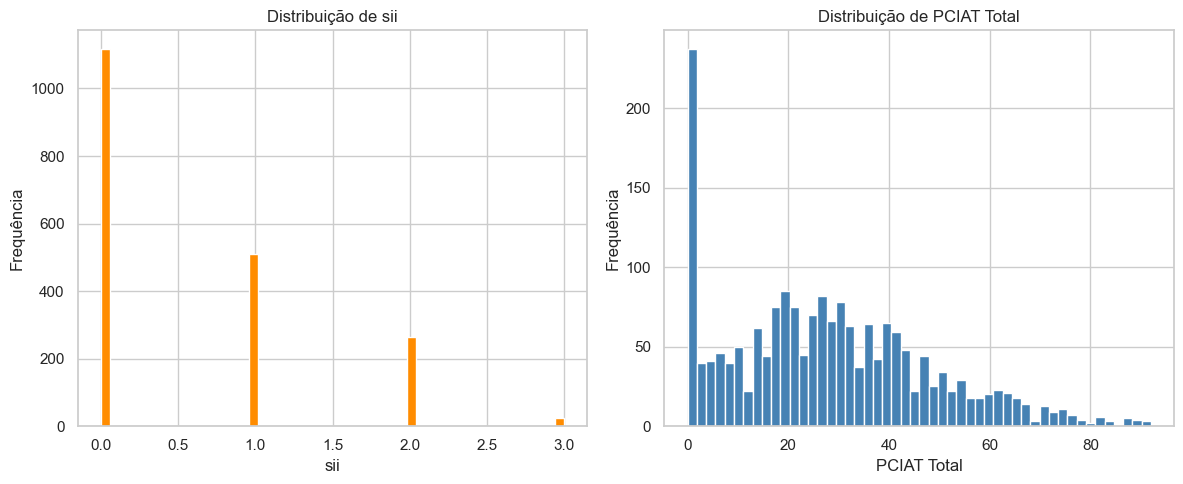

In [584]:
# Distribuição gráfica das pontuações totais que determinam o sii
# desbalanceamento

# Configurações gerais
sns.set_theme(style="whitegrid")

# Criar dois gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 linha, 2 colunas

# Gráfico 1: Distribuição de 'sii'
axes[0].hist(train['sii'], bins=50, color="darkorange")
axes[0].set_title('Distribuição de sii')
axes[0].set_xlabel('sii')
axes[0].set_ylabel('Frequência')

# Gráfico 2: Distribuição de outra coluna (ex: 'PCIAT-PCIAT_Total')
axes[1].hist(train['PCIAT-PCIAT_Total'], bins=50, color="steelblue")
axes[1].set_title('Distribuição de PCIAT Total')
axes[1].set_xlabel('PCIAT Total')
axes[1].set_ylabel('Frequência')

# Mostrar os gráficos
plt.tight_layout()
plt.show()


## 2.3 Imputação de Valores Faltantes e Rotulação

A classe a seguir  é usada para imputar valores ausentes em um conjunto de dados, utilizando:

- Modelo de Machine Learning para prever valores ausentes com base em outras colunas.
- Média dos valores conhecidos, caso um modelo não possa ser treinado para uma coluna.

In [585]:
class Impute_With_Model:
    
    def __init__(self, na_frac=0.5, min_samples=0):
        self.model_dict = {}
        self.mean_dict = {}
        self.features = None
        self.na_frac = na_frac
        self.min_samples = min_samples
        
    def find_features(self, data, feature, tmp_features):
        missing_rows = data[feature].isna()
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_features = np.array(tmp_features)[na_fraction <= self.na_frac]
        return valid_features

    def fit_models(self, model, data, features):
        self.features = features
        n_data = data.shape[0]
        for feature in features:
            self.mean_dict[feature] = np.mean(data[feature])
        for feature in tqdm(features):
            if data[feature].isna().sum() > 0:
                model_clone = clone(model)
                X = data[data[feature].notna()].copy()
                tmp_features = [f for f in features if f != feature]
                tmp_features = self.find_features(data, feature, tmp_features)
                if len(tmp_features) >= 1 and X.shape[0] > self.min_samples:
                    for f in tmp_features:
                        X[f] = X[f].fillna(self.mean_dict[f])
                    model_clone.fit(X[tmp_features], X[feature])
                    self.model_dict[feature] = (model_clone, tmp_features.copy())
                else:
                    self.model_dict[feature] = ("mean", np.mean(data[feature]))
            
    def impute(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data[feature].fillna(model[1], inplace=True)
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    imputed_data.loc[missing_rows, feature] = model[0].predict(X_missing[model[1]])
        return imputed_data

In [586]:
class ImputadorComModelo:
    
    def __init__(self, frac_na=0.5, amostras_minimas=0):
        self.dict_modelos = {}  # Dicionário para armazenar modelos por coluna
        self.dict_medias = {}   # Dicionário para armazenar médias por coluna
        self.variaveis = None   # Lista de variáveis (colunas)
        self.frac_na = frac_na  # Fração máxima de valores ausentes permitida
        self.amostras_minimas = amostras_minimas  # Número mínimo de amostras para treinar um modelo
        
    def encontrar_variaveis_validas(self, dados, variavel, variaveis_temp):
        linhas_ausentes = dados[variavel].isna()
        frac_ausentes = dados[linhas_ausentes][variaveis_temp].isna().mean(axis=0)
        variaveis_validas = np.array(variaveis_temp)[frac_ausentes <= self.frac_na]
        return variaveis_validas

    def ajustar_modelos(self, modelo, dados, variaveis):
        self.variaveis = variaveis
        for variavel in variaveis:
            self.dict_medias[variavel] = np.mean(dados[variavel])
        
        for variavel in tqdm(variaveis):
            if dados[variavel].isna().sum() > 0:
                modelo_clonado = clone(modelo)
                X = dados[dados[variavel].notna()].copy()
                variaveis_temp = [v for v in variaveis if v != variavel]
                variaveis_temp = self.encontrar_variaveis_validas(dados, variavel, variaveis_temp)
                
                if len(variaveis_temp) >= 1 and X.shape[0] > self.amostras_minimas:
                    for v in variaveis_temp:
                        X[v] = X[v].fillna(self.dict_medias[v])
                    modelo_clonado.fit(X[variaveis_temp], X[variavel])
                    self.dict_modelos[variavel] = (modelo_clonado, variaveis_temp.copy())
                else:
                    self.dict_modelos[variavel] = ("media", np.mean(dados[variavel]))
            
    def imputar(self, dados):
        dados_imputados = dados.copy()
        for variavel, modelo in self.dict_modelos.items():
            linhas_ausentes = dados_imputados[variavel].isna()
            if linhas_ausentes.any():
                if modelo[0] == "media":
                    dados_imputados[variavel].fillna(modelo[1], inplace=True)
                else:
                    variaveis_temp = [v for v in self.variaveis if v != variavel]
                    X_faltantes = dados.loc[linhas_ausentes, variaveis_temp].copy()
                    for v in variaveis_temp:
                        X_faltantes[v] = X_faltantes[v].fillna(self.dict_medias[v])
                    dados_imputados.loc[linhas_ausentes, variavel] = modelo[0].predict(X_faltantes[modelo[1]])
        return dados_imputados


In [587]:

#Identificar  colunas com uma quantidade significativa de valores ausentes.

missing = pd.DataFrame(train.isna().sum() / len(train))
missing[missing[0] > 0.3]

,0
Physical-Waist_Circumference,0.817232
Fitness_Endurance-Max_Stage,0.740992
Fitness_Endurance-Time_Mins,0.742559
Fitness_Endurance-Time_Sec,0.742559
BIA-BIA_Activity_Level_num,0.335770
BIA-BIA_BMC,0.335770
BIA-BIA_ECW,0.335770
BIA-BIA_FFMI,0.335770
BIA-BIA_FMI,0.335770
BIA-BIA_Fat,0.335770


In [588]:
model = LassoCV(cv=5, random_state=42)
imputer = Impute_With_Model(na_frac=0.4) 
# na_frac é a fração máxima de valores ausentes até a qual um recurso é imputado com o modelo
# se houver mais valores ausentes do que, por exemplo, 40%, então voltamos à imputação média
imputer.fit_models(model, train, features)
train = imputer.impute(train)
test = imputer.impute(test)

  0%|          | 0/45 [00:00<?, ?it/s]c:\Users\Elke\Desktop\TCC\tcc-eng-mecatronica-ufrn\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.80365482644993, tolerance: 18.55002756508423
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Elke\Desktop\TCC\tcc-eng-mecatronica-ufrn\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.91146378510166, tolerance: 18.55002756508423
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Elke\Desktop\TCC\tcc-eng-mecatronica-ufrn\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.04195056963363, tolerance: 18.55002756508423
  model = cd_f

In [589]:
# Salvar como CSV
train.to_csv('train_database1.csv', index=False)
test.to_csv('test.csv', index=False)

In [590]:
# Salvar como CSV
train.to_csv('train_original.csv', index=False)
test.to_csv('test.original', index=False)